# Linear Regression
## By Chase Whitman

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

# Set pandas option to view all columns
pd.set_option('display.max_columns', None)

## Read In Data

In [46]:
df = pd.read_csv("../Datasets//churn_clean.csv")

TypeError: parser_f() got an unexpected keyword argument 'index'

In [3]:
df.shape

(10000, 50)

In [4]:
df.columns

Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
       'Children', 'Age', 'Income', 'Marital', 'Gender', 'Churn',
       'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure',
       'Techie', 'Contract', 'Port_modem', 'Tablet', 'InternetService',
       'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'Tenure', 'MonthlyCharge',
       'Bandwidth_GB_Year', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5',
       'Item6', 'Item7', 'Item8'],
      dtype='object')

## Data Preprocessing

In [5]:
print('Shape of dataframe:')
print('Before drop:', df.shape)

# Drop columns that contain unique values
unique_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID']

# Multiple columns are used to decribe location. Timezone will be used as a regional reference.
# The additional location columns will be dropped.
location_columns = ['City', 'State','County', 'Zip', 'Lat', 'Lng', 'Job']

# Apply the drop
df.drop(columns=(unique_columns+location_columns), inplace=True)

print('After drop:', df.shape)

Shape of dataframe:
Before drop: (10000, 50)
After drop: (10000, 39)


In [6]:
# Columns that contain binary values (Y/N)
binary_columns = ['Churn', 'Techie', 'Port_modem', 'Tablet', 'Phone', 'Multiple', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

# Convert values to 1s/0s
for col in binary_columns:
    df[col] = df[col].map(dict(Yes=1, No=0))

# Examine results
df[binary_columns].head()

,Churn,Techie,Port_modem,Tablet,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling
0,0,0,1,1,1,0,1,1,0,0,0,1,1
1,1,1,0,1,1,1,1,0,0,0,1,1,1
2,0,1,1,0,1,1,0,0,0,0,0,1,1
3,0,1,0,0,1,0,1,0,0,0,1,0,1
4,1,0,1,0,0,0,0,0,0,1,1,0,0


In [7]:
# One hot encode columns with multiple unique values
dummy_columns = ['Area', 'TimeZone']
df = pd.get_dummies(df, columns=dummy_columns, drop_first=True)

In [8]:
# One hot encode Internet Service based on Fiber Optic and DSL values
df['InternetService_FiberOptic'] = np.where(df.InternetService == 'Fiber Optic', 1, 0)
df['InternetService_DSL'] = np.where(df.InternetService == 'DSL', 1, 0)

# Examine results
print(df[['InternetService', 'InternetService_DSL', 'InternetService_FiberOptic']].head(8))

# Drop original Internet Service column
df.drop(columns='InternetService', inplace=True)

  InternetService  InternetService_DSL  InternetService_FiberOptic
0     Fiber Optic                    0                           1
1     Fiber Optic                    0                           1
2             DSL                    1                           0
3             DSL                    1                           0
4     Fiber Optic                    0                           1
5            None                    0                           0
6             DSL                    1                           0
7             DSL                    1                           0


In [9]:
# One hot encode Gender based on Male and Female
df['Gender_Male'] = np.where(df.Gender == 'Male', 1, 0)
df['Gender_Female'] = np.where(df.Gender == 'Female', 1, 0)

# Examine results
print(df[['Gender', 'Gender_Male', 'Gender_Female']].head(10))

# Drop original Gender column
df.drop(columns='Gender', inplace=True)

      Gender  Gender_Male  Gender_Female
0       Male            1              0
1     Female            0              1
2     Female            0              1
3       Male            1              0
4       Male            1              0
5     Female            0              1
6       Male            1              0
7     Female            0              1
8  Nonbinary            0              0
9     Female            0              1


In [10]:
# Reduce Marital categories into two types: 
#   Married:1 
#   Not Married:0
df['Marital'] = np.where(df.Marital == 'Married',1,0)

In [11]:
# One hot encode Payment Method based on automatic payments or checks
df['PaymentMethod_Auto'] = np.where(np.logical_or(df.PaymentMethod == 'Credit Card (automatic)', 
                       df.PaymentMethod == 'Bank Transfer(automatic)'), 1, 0)
df['PaymentMethod_Check'] = np.where(np.logical_or(df.PaymentMethod == 'Mailed Check', 
                       df.PaymentMethod == 'Electronic Check'), 1, 0)

# Examine results
print(df[['PaymentMethod', 'PaymentMethod_Auto', 'PaymentMethod_Check']].head(8))

# Drop original Payment Method column
df.drop(columns='PaymentMethod', inplace=True)

              PaymentMethod  PaymentMethod_Auto  PaymentMethod_Check
0   Credit Card (automatic)                   1                    0
1  Bank Transfer(automatic)                   1                    0
2   Credit Card (automatic)                   1                    0
3              Mailed Check                   0                    1
4              Mailed Check                   0                    1
5          Electronic Check                   0                    1
6          Electronic Check                   0                    1
7              Mailed Check                   0                    1


In [12]:
# Convert Contract type into numerical values based on the year value
df['Contract'] = df['Contract'].replace({'Month-to-month':0, 'One year':1, 'Two Year':2})

In [13]:
# Examine Results
df.head()

,Population,Children,Age,Income,Marital,Churn,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Techie,Contract,Port_modem,Tablet,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Tenure,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Area_Suburban,Area_Urban,TimeZone_America/Boise,TimeZone_America/Chicago,TimeZone_America/Denver,TimeZone_America/Detroit,TimeZone_America/Indiana/Indianapolis,TimeZone_America/Indiana/Knox,TimeZone_America/Indiana/Marengo,TimeZone_America/Indiana/Petersburg,TimeZone_America/Indiana/Tell_City,TimeZone_America/Indiana/Vincennes,TimeZone_America/Indiana/Winamac,TimeZone_America/Juneau,TimeZone_America/Kentucky/Louisville,TimeZone_America/Los_Angeles,TimeZone_America/Menominee,TimeZone_America/New_York,TimeZone_America/Nome,TimeZone_America/North_Dakota/New_Salem,TimeZone_America/Ojinaga,TimeZone_America/Phoenix,TimeZone_America/Puerto_Rico,TimeZone_America/Sitka,TimeZone_America/Toronto,TimeZone_Pacific/Honolulu,InternetService_FiberOptic,InternetService_DSL,Gender_Male,Gender_Female,PaymentMethod_Auto,PaymentMethod_Check
0,38,0,68,28561.99,0,0,7.978323,10,0,1,0,1,1,1,1,0,1,1,0,0,0,1,1,6.795513,172.455519,904.536110,5,5,5,3,4,4,3,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
1,10446,1,27,21704.77,1,1,11.699080,12,0,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1.156681,242.632554,800.982766,3,4,3,3,4,3,4,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
2,3735,4,50,9609.57,0,0,10.752800,9,0,1,1,2,1,0,1,1,0,0,0,0,0,1,1,15.754144,159.947583,2054.706961,4,4,2,4,4,3,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
3,13863,1,48,18925.23,1,0,14.913540,15,2,0,1,2,0,0,1,0,1,0,0,0,1,0,1,17.087227,119.956840,2164.579412,4,4,4,2,5,4,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
4,11352,0,83,40074.19,0,1,8.147417,16,2,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1.670972,149.948316,271.493436,4,4,4,3,4,4,4,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


In [14]:
df.shape

(10000, 66)

## Explore data distributions and relationships

In [15]:
# Heatmap function 
def plot_heatmap(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f,ax = plt.subplots(figsize=(13,9))
    cmap = sns.diverging_palette(20, 220, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.5, vmax=.5, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

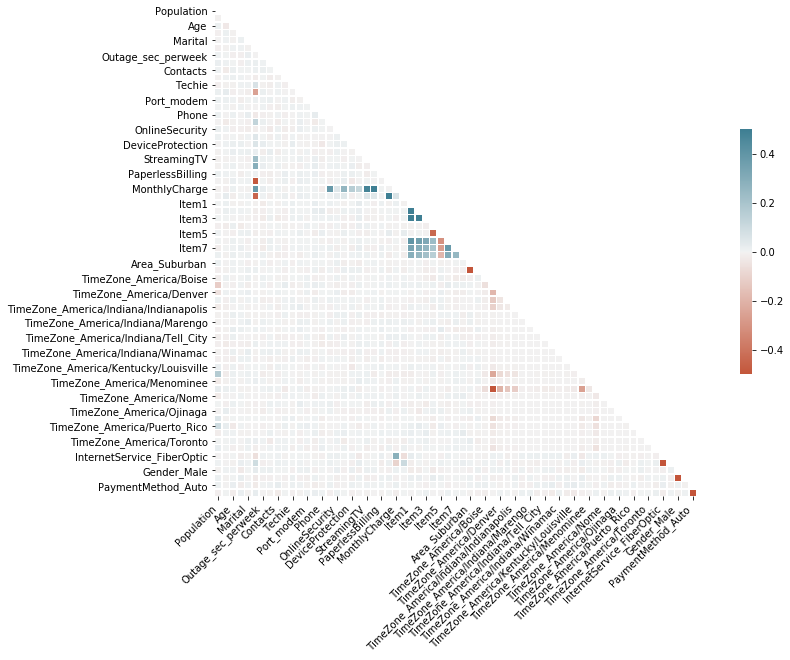

In [16]:
plot_heatmap(df)

In [17]:
# Print out features with correlation values above 0.3
corr_list = df.corr()['Tenure'].to_list()
for n in corr_list:
    if abs(n) > 0.3 and abs(n) != 1.0:
        print(df.columns.to_list()[corr_list.index(n)], n)

Churn -0.4854750270854005
Bandwidth_GB_Year 0.9914951921640224


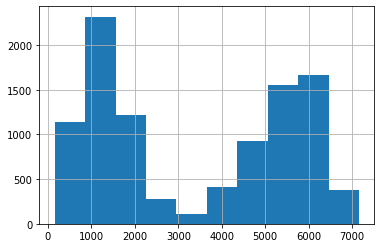

In [18]:
# Bandwidth histogram
df.Bandwidth_GB_Year.hist()

C:\Users\chase\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


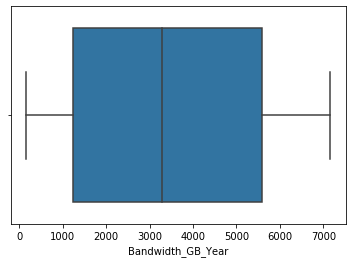

In [19]:
# Bandwidth boxplot
sns.boxplot(df.Bandwidth_GB_Year)

C:\Users\chase\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


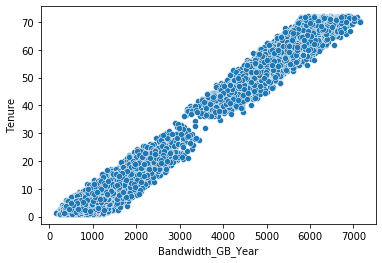

In [20]:
# Bandwidth scatterplot
sns.scatterplot(df.Bandwidth_GB_Year, df.Tenure)

In [21]:
# Churn summary: value counts
df.Churn.value_counts()

0    7350
1    2650
Name: Churn, dtype: int64

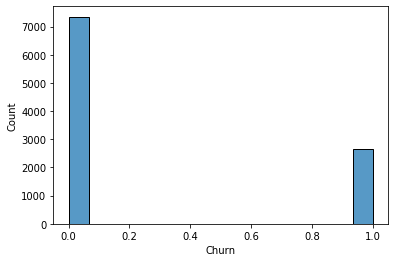

In [22]:
# Churn histogram
sns.histplot(df.Churn)

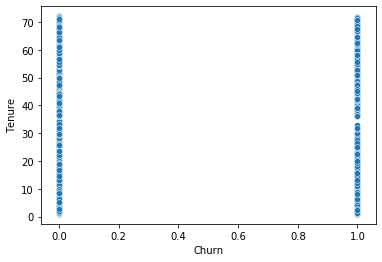

In [23]:
# Churn scatterplot
sns.scatterplot(x=df.Churn, y=df.Tenure)

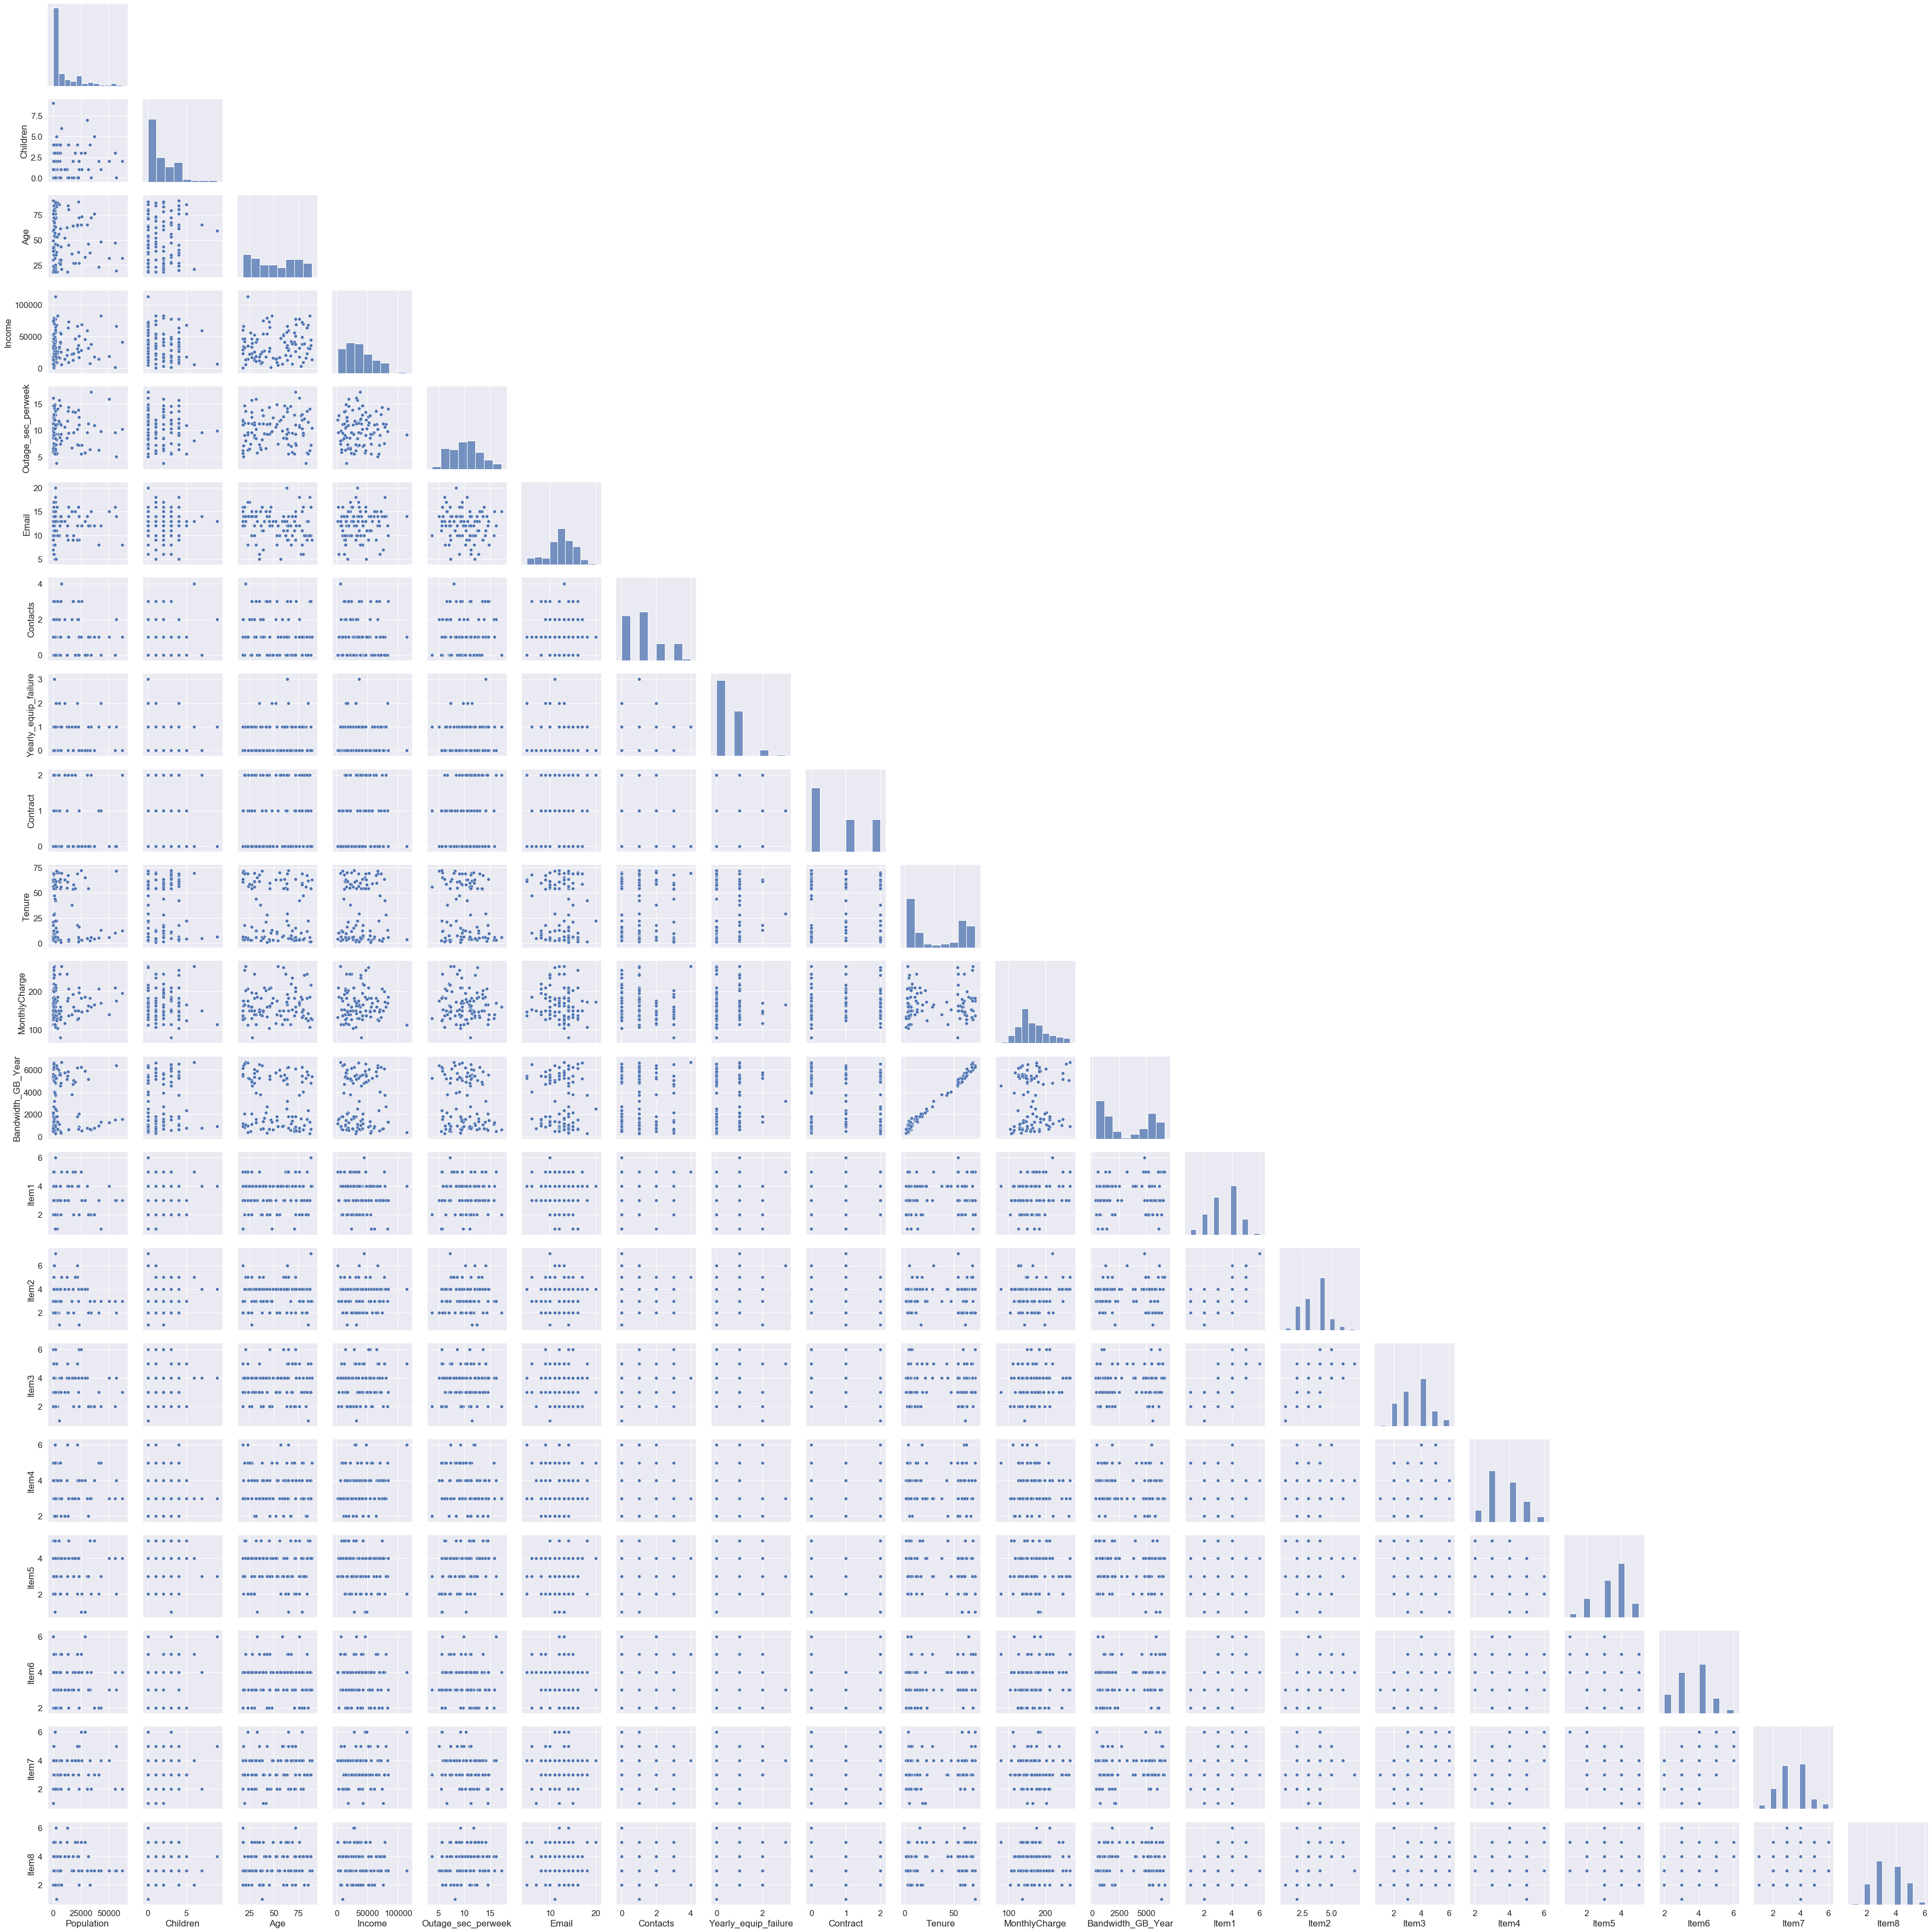

In [24]:
# The following creates a pairplot for all non-binary variables
c_list = []
for col in df.columns:
    if len(df[col].unique()) > 2:
        c_list.append(col)
df_pairplot = df[c_list]

sns.set(font_scale=1.4)
sns.pairplot(data=df_pairplot.sample(100), corner=True)


### Scale and split data

The variable I will be predicting is Tenure

In [25]:
# Separate into predictor variables and target variable
X = df.drop('Tenure',1)
y = df[['Tenure']]

In [26]:
# Split into train and test datasets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Standardize data using Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

## Define function to examine results

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Function to print MAE, MSE, and R-squared scores
def calc_results(y_test, pred):
    mae = mean_absolute_error(y_test,pred)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
        
    print('Mean Absolute Error: %s' %mae)
    print('Mean Squared Error: %s' %mse)
    print('R-squared: %s' %r2)

In [29]:
import math

# Function to calculate and print the RMSE for Training and Test Data
# Prints the models coefficients
def calculate_rmse(y_true, y_pred):
    return(math.sqrt(np.sum((y_true - y_pred)**2)/len(y_true)))

def print_rmse(y_train, y_test, model, pred):
    train_rmse = calculate_rmse(y_train, model.predict(X_train))
    test_rmse = calculate_rmse(y_test, pred)
    
    print(f'Training RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    print('')
    print(f'Model coefficients:\n{model.coef_}')

## Linear regression

In [30]:
def regression_linear(X_train, X_test, y_train):
    reg = LinearRegression().fit(X_train, y_train)
    prediction = reg.predict(X_test)
    return reg, prediction

In [31]:
lr_model, lr_predictions = regression_linear(X_train, X_test, y_train)

print('------ Linear Regression Model ------\n')
print_rmse(y_train, y_test, lr_model, lr_predictions)
print('')
calc_results(y_test, lr_predictions)

------ Linear Regression Model ------

Training RMSE: 0.10694397556108827
Test RMSE: 0.10795107060867278

Model coefficients:
[[-1.49281001e-04 -8.00948684e-01  8.26706059e-01  1.04482795e-03
   3.83550936e-04  3.06946061e-03  2.29661279e-04 -4.69467984e-04
   4.74124031e-04 -2.82928952e-04 -1.22592638e-04  1.28721203e-03
   1.37704449e-03  1.54217622e-05 -4.74982562e-04  1.33440064e-01
  -3.96657192e-01 -1.75834869e-01 -2.96825937e-01  1.86472195e-01
  -6.49932787e-01 -3.61845309e-01 -1.98169184e-03 -1.50590425e+00
   2.67084554e+01  2.04047905e-03 -3.97463217e-04  1.36712290e-03
  -1.25664254e-03 -2.67895440e-03 -2.31063406e-03 -1.36287760e-03
   8.39908906e-04 -3.50134173e-03 -2.88722501e-03 -1.35665291e-03
   3.70068425e-03  2.95060121e-03  1.71688631e-03 -2.92542506e-04
  -1.11610201e-03  1.17976023e-03  7.92199355e-04  4.93097954e-04
  -1.66859251e-03  1.13736298e-03  1.86328312e-03  1.96546664e-04
  -3.26738671e-04  1.95699150e-03  2.49729647e-03  1.32490021e-04
   1.82369540e-0

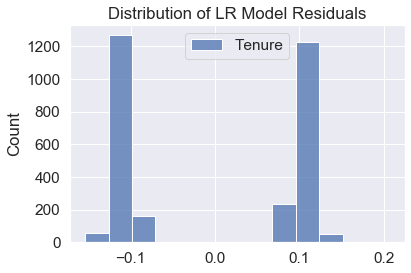

In [32]:
lr_residuals = y_test - lr_predictions
sns.histplot(lr_residuals)
plt.title('Distribution of LR Model Residuals')
plt.show()

C:\Users\chase\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


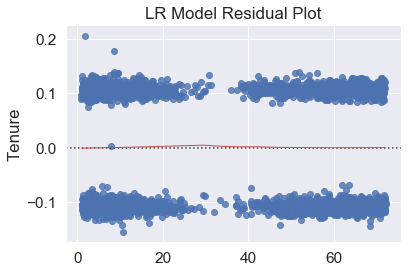

In [33]:
sns.residplot(lr_predictions.reshape(-1), y_test, lowess=True, 
              line_kws={'color':'r', 'lw':1, 'alpha':1})
plt.title('LR Model Residual Plot')
plt.show()

Text(0.5, 1.0, 'LR Model Normal Q-Q Plot')

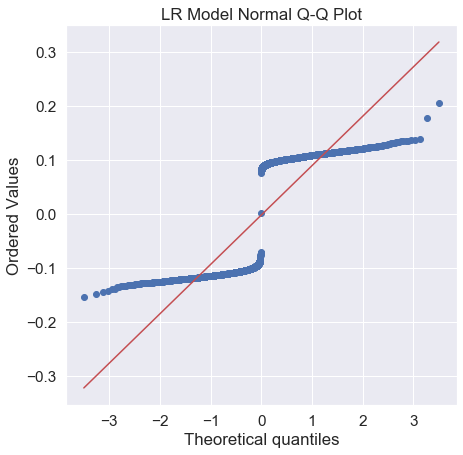

In [34]:
# QQ Plot for LR Model residuals
plt.figure(figsize=(7,7))
stats.probplot(lr_residuals.Tenure, dist='norm', plot=plt)
plt.title('LR Model Normal Q-Q Plot')

## Feature Selection: LassoCV

In [35]:
from sklearn.linear_model import LassoCV

# Define Lasso Regression function
def regression_lasso(X_train, X_test, y_train, random_state=42):
    reg = LassoCV(cv=10, random_state=random_state).fit(X_train, y_train)
    pred = reg.predict(X_test)
    return reg, pred 

In [36]:
lasso_model, lasso_predictions = regression_lasso(X_train, X_test, y_train)

print('------ Lasso Regression Model ------\n')
print_rmse(y_train.Tenure, y_test.Tenure, lasso_model, lasso_predictions)
print('')
calc_results(y_test.Tenure, lasso_predictions)

# print(f'Training RMSE: {calculate_rmse(y_train.Tenure, lasso_model.predict(X_train))}')
# print(f'Test RMSE: {calculate_rmse(y_test.Tenure, lasso_predictions)}')
# print('')
# print(f'Model coefficients:\n{lasso_model.coef_}')

print()
print(f'The shrinkage coefficient hyperparameter chosen by CV: {lasso_model.alpha_}')

------ Lasso Regression Model ------

Training RMSE: 0.15270979931764078
Test RMSE: 0.15579117484924582

Model coefficients:
[-0.00000000e+00 -7.75007961e-01  8.00111149e-01  0.00000000e+00
 -0.00000000e+00 -1.26459162e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  3.03243206e-02
 -3.76696971e-01 -1.99640033e-01 -3.03299932e-01  1.32041351e-01
 -7.20704251e-01 -4.57592156e-01 -0.00000000e+00 -1.29962663e+00
  2.66653849e+01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+

C:\Users\chase\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
# Identify which features were dropped/retained 
# Creates a dictionary for retained features and their coefficients
# and a list of dropped features
features_dict = {}
dropped_features = []
for n in range(len(lasso_model.coef_)):
    if lasso_model.coef_[n] != 0:
        features_dict[X.columns[n]] = lasso_model.coef_[n]
    else:
        dropped_features.append(X.columns[n])
        

In [38]:
# Print the retained features and their coefficients after L1 Regularization
{k: v for k,v in sorted(features_dict.items(), key=lambda item: item[1], reverse=True)}

{'Bandwidth_GB_Year': 26.665384940217766,
 'Age': 0.8001111486863018,
 'InternetService_FiberOptic': 0.47939649860123784,
 'TechSupport': 0.13204135097908826,
 'Multiple': 0.030324320588156622,
 'Churn': -0.012645916190130996,
 'OnlineBackup': -0.1996400326805843,
 'DeviceProtection': -0.303299932381525,
 'Gender_Male': -0.3750533067803292,
 'OnlineSecurity': -0.3766969714709441,
 'StreamingMovies': -0.45759215581681,
 'StreamingTV': -0.7207042513712532,
 'Children': -0.7750079610483639,
 'MonthlyCharge': -1.2996266302315573,
 'InternetService_DSL': -2.1924196144832795}

In [39]:
print('The following features were dropped:') 
dropped_features

The following features were dropped:


['Population',
 'Income',
 'Marital',
 'Outage_sec_perweek',
 'Email',
 'Contacts',
 'Yearly_equip_failure',
 'Techie',
 'Contract',
 'Port_modem',
 'Tablet',
 'Phone',
 'PaperlessBilling',
 'Item1',
 'Item2',
 'Item3',
 'Item4',
 'Item5',
 'Item6',
 'Item7',
 'Item8',
 'Area_Suburban',
 'Area_Urban',
 'TimeZone_America/Boise',
 'TimeZone_America/Chicago',
 'TimeZone_America/Denver',
 'TimeZone_America/Detroit',
 'TimeZone_America/Indiana/Indianapolis',
 'TimeZone_America/Indiana/Knox',
 'TimeZone_America/Indiana/Marengo',
 'TimeZone_America/Indiana/Petersburg',
 'TimeZone_America/Indiana/Tell_City',
 'TimeZone_America/Indiana/Vincennes',
 'TimeZone_America/Indiana/Winamac',
 'TimeZone_America/Juneau',
 'TimeZone_America/Kentucky/Louisville',
 'TimeZone_America/Los_Angeles',
 'TimeZone_America/Menominee',
 'TimeZone_America/New_York',
 'TimeZone_America/Nome',
 'TimeZone_America/North_Dakota/New_Salem',
 'TimeZone_America/Ojinaga',
 'TimeZone_America/Phoenix',
 'TimeZone_America/Puerto

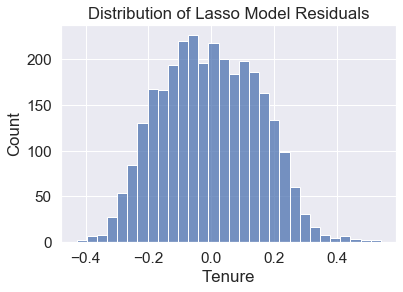

In [40]:
# Lasso Model histogram
lasso_residuals = y_test.Tenure - lasso_predictions
sns.histplot(lasso_residuals)
plt.title('Distribution of Lasso Model Residuals')
plt.show()

C:\Users\chase\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


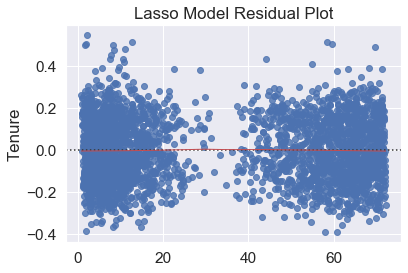

In [41]:
# Lasso Model residual plot
sns.residplot(lasso_predictions.reshape(-1), y_test, lowess=True, 
              line_kws={'color':'r', 'lw':1, 'alpha':1})
plt.title('Lasso Model Residual Plot')
plt.show()

Text(0.5, 1.0, 'Normal Q-Q Plot')

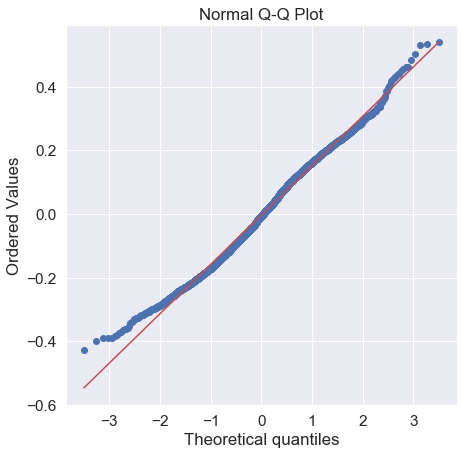

In [42]:
# QQ Plot for Lasso Model residuals
plt.figure(figsize=(7,7))
stats.probplot(lasso_residuals, dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')